In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, Softmax
from tensorflow.keras.utils import to_categorical
#from tensorflow import keras 
import numpy as np
from glob import glob 
#np.random.seed(66)

In [2]:
import tensorflow as tf

In [4]:
i = 0 
for file in glob('data_crop/positive/*16x16x10.npy'):
    if i==0:
        data = np.load(file)
        i=1
    else:
        data2 = np.load(file)
        data = np.concatenate((data,data2))        
data.shape

(74, 16, 16, 10)

In [5]:
i = 0 
for file in glob('data_crop/negative/*16x16x10.npy'):
    if i==0:
        data_false = np.load(file)
        i=1
    else:
        data2 = np.load(file)
        data_false = np.concatenate((data_false,data2))        
data_false.shape

(80, 16, 16, 10)

In [6]:
fulldata = np.concatenate((data,data_false))
fulldata.shape

(154, 16, 16, 10)

In [7]:
ones = [1 for i in range(data.shape[0])]
zeros = [0 for i in range(data_false.shape[0])]
y = ones + zeros
y = np.array(y)
y = y.reshape(-1,1)
y.shape

(154, 1)

In [8]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y)
onehotlabels = enc.transform(y).toarray()
onehotlabels.shape

/home/offsouza/miniconda3/envs/mri/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(154, 2)

In [9]:
fulldata_res = fulldata.reshape(154,16,16,10,1)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fulldata_res, onehotlabels, test_size=0.3,shuffle= True)

In [11]:
ishape = (16,16,10,1) #4672 #2336500

#ishape = (20,20,16,1) #4672 #2336500


In [12]:
import  os
import  tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, optimizers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [13]:
strides=(1, 1, 1)
padding = 'valid'

In [14]:

class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 3D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = 'tf'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[4]

    def compute_output_shape(self, input_shape):
        print((input_shape[0], self.nb_channels * self.num_outputs_per_channel))
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = x.shape        

        if self.dim_ordering == 'th':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
            
        elif self.dim_ordering == 'tf':
            num_rows = input_shape[1]
            num_cols = input_shape[2]
            num_depth = input_shape[3]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]        
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]
        depth_length = [K.cast(num_depth, 'float32') / i for i in self.pool_list]
        outputs = []

        if self.dim_ordering == 'th':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'tf':            
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for zz in range(num_pool_regions):                    
                    for jy in range(num_pool_regions):                        
                        for ix in range(num_pool_regions):                            
                            x1 = ix * col_length[pool_num]
                            x2 = ix * col_length[pool_num] + col_length[pool_num]
                            y1 = jy * row_length[pool_num]
                            y2 = jy * row_length[pool_num] + row_length[pool_num]
                            z1 = zz * depth_length[pool_num]
                            z2 = zz * depth_length[pool_num] + depth_length[pool_num]
                            
                            x1 = K.cast(K.round(x1), 'int32')
                            x2 = K.cast(K.round(x2), 'int32')
                            y1 = K.cast(K.round(y1), 'int32')
                            y2 = K.cast(K.round(y2), 'int32')
                            z1 = K.cast(K.round(z1), 'int32')
                            z2 = K.cast(K.round(z2), 'int32')                            
                            

                            new_shape = [input_shape[0], y2 - y1,
                                         x2 - x1, z2 - z1, input_shape[4]]
                            

                            x_crop = x[:, y1 -y2, x1-x2, z1-z2, :]
                            
                      
                            outputs.append(x_crop)
        
                
            
        if self.dim_ordering == 'th':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'tf':
            
            outputs = K.concatenate(outputs)
            
        return outputs

In [15]:
model = tf.keras.Sequential()


model.add(Conv3D(32, (7,7,5), strides=strides, padding=padding, input_shape=ishape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (5,5,3), strides=strides, padding=padding))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SpatialPyramidPooling([1,2,4]))
model.add(Dense(500))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 10, 6, 32)     7872      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 6, 32)     128       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 6, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 6, 32)     0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 3, 32)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 1, 64)       153664    
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 1, 64)       0

In [16]:
# treinamento keras
# compilando o otimizador, função de perda e metricas
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
epochs = 1000

check = ModelCheckpoint(filepath='./weights_seq2keras21_09.hdf5', verbose=0, save_best_only=True, monitor='val_loss')
early = EarlyStopping(monitor='val_loss',patience=3)

# train
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_test, y_test),
         verbose=1, callbacks=[ check, early])



Epoch 1/1000
2/2 [==============================] - 3s 2s/step - loss: 0.8795 - accuracy: 0.5421 - val_loss: 0.6962 - val_accuracy: 0.5319
Epoch 2/1000
2/2 [==============================] - 0s 137ms/step - loss: 0.4861 - accuracy: 0.7757 - val_loss: 0.6948 - val_accuracy: 0.5319
Epoch 3/1000
2/2 [==============================] - 0s 167ms/step - loss: 0.4388 - accuracy: 0.8037 - val_loss: 0.6805 - val_accuracy: 0.5532
Epoch 4/1000
2/2 [==============================] - 0s 139ms/step - loss: 0.3258 - accuracy: 0.8785 - val_loss: 0.6722 - val_accuracy: 0.5319
Epoch 5/1000
2/2 [==============================] - 0s 203ms/step - loss: 0.4069 - accuracy: 0.8411 - val_loss: 0.6673 - val_accuracy: 0.5745
Epoch 6/1000
2/2 [==============================] - 0s 69ms/step - loss: 0.3692 - accuracy: 0.8411 - val_loss: 0.6724 - val_accuracy: 0.5532
Epoch 7/1000
2/2 [==============================] - 0s 78ms/step - loss: 0.3028 - accuracy: 0.8879 - val_loss: 0.6965 - val_accuracy: 0.5319
Epoch 8/100

In [17]:
# evaluate on test set
scores = model.evaluate(X_test, y_test, batch_size, verbose=1)
print("Final test loss and accuracy :", scores)

1/1 [==============================] - 0s 1ms/step - loss: 0.7013 - accuracy: 0.5319
Final test loss and accuracy : [0.70134437084198, 0.5319148898124695]


In [18]:
model.save('./tf_model/3dcnn_SPP16_2909')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./tf_model/3dcnn_SPP16_2909/assets


In [19]:
for i in history.history:
    print(i)

loss
accuracy
val_loss
val_accuracy


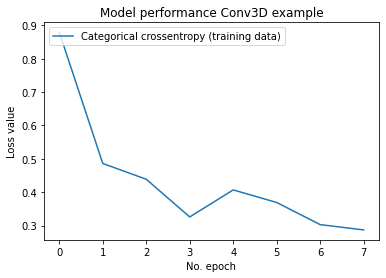

In [20]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
#plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
#plt.plot(history.history['accuracy'], label='Accuracy (training data)')
#plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

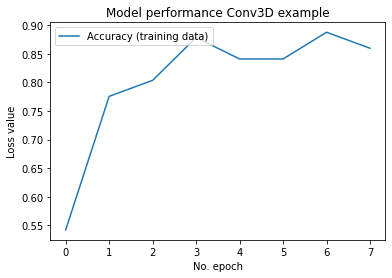

In [21]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
#plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
#plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
#plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()